## MNIST Data

group: Fabian Widmer, Stefano Balestra, Antonio Rosolia

Full classification of MNIST data.

The original MNIST dataset is used.

The following notation is used: <br>
<code>m</code>: Number of samples <br>
<code>n</code>: Number of features

Here the features refer to the pixel values of the images.

### Notes:
- Those are notes for the group, prior to the 11.10. there was an error in the notebook, this was fixed.
- Therefore the notes are not importnat anymore but they give insights on what was done.
- It does not run as expected!
--> it looks like it is overfitting because the train error gets smaller and smaller but the test error is at a minimum (not a good minimum!) after just ~5 epochs and is increasing after that!
- there must be a mistake somewhere in the notebook
- also the test cost is not a number after ~4-5 epochs --> why?
- this leads to a wrong plot in the plot_cost_curve
-  norm goes to infinety --> leads to nan in ypred -> 
   leads to nan in p -> leads to nan in ypred_test (only with test data!)
   --> X test data must be flawed! x_test has the right shape (10,14000) 
   and consists of zeros


### Data Folder

The data can be loaded by using suitable functionality in sklearn which will use a dedicated folder on your local disk for caching. Specify the folder to be used. 

In [96]:
### START YOUR CODE ### 
import os
data_home = "./mnist-data"
if not os.path.exists(data_home):
    os.makedirs(data_home)
### END YOUR CODE ### 

### Data Preparation

Some preparatory steps to be applied before training:
* Loading the data
* Some plots
* Extracting two digits and restricting the classification task to that so that the dataset is well balanced.
* Splitting the dataset into train and test
* Normalizing the intensities to the range [-1,1]

#### Plotting Utility

In [97]:
import numpy as np 
import matplotlib.pyplot as plt

def plot_img(img, label, shape):
    """
    Plot the x array by reshaping it into a square array of given shape
    and print the label.
    
    Parameters:
    img -- array with the intensities to be plotted of shape (shape[0]*shape[1])
    label -- label 
    shape -- 2d tuple with the dimensions of the image to be plotted.
    """
    plt.imshow(np.reshape(img, shape), cmap=plt.cm.gray)
    plt.title("Label %i"%label)


def plot_digits(x,y,selection,shape, cols=5):
    """
    Plots the digits in a mosaic with given number of columns.

    Arguments:
    x -- array of images of size (n,m)
    y -- array of labels of size (1,m)
    selection -- list of selection of samples to be plotted
    shape -- shape of the images (a 2d tuple)
    selected_digits -- tuple with the two selected digits (the first associated with label 1, the second with label 0)
    """
    if len(selection)==0:
        print("No images in the selection!")
        return
    cols = min(cols, len(selection))
    rows = len(selection)/cols+1
    plt.figure(figsize=(20,4*rows))
    for index, (image, label) in enumerate(zip(x.T[selection,:], y.T[selection,:])):
        plt.subplot(rows, cols, index+1)
        plt.imshow(np.reshape(image, shape), cmap=plt.cm.gray)
        plt.title('Sample %i\n Label %i\n' % (selection[index],label), fontsize = 12)
    plt.tight_layout()

#### Load Data

In [98]:
import numpy as np
from sklearn.datasets import fetch_openml
#from sklearn import *
#import sklearn as sklearn

def load_mnist(data_home):
    """
    Loads the mnist dataset, prints the shape of the dataset and 
    returns the array with the images, the array with associated labels 
    and the shape of the images.     
    Parameters: 
    data_home -- Absolute path to the DATA_HOME  
    
    Returns:
    x -- array with images of shape (784,m) where m is the number of images
    y -- array with associated labels with shape (1,m) where m is the number of images
    shape -- (28,28)
    """
    #print(sklearn)
    #print(sklearn.__version__)
    mnist = fetch_openml(name='mnist_784', version=1, cache=True, data_home=data_home)
    x, y = mnist['data'].T, np.array(mnist['target'], dtype='int').T
    m = x.shape[1]
    y = y.reshape(1,m)
    print("Loaded MNIST original:")
    print("Image Data Shape" , x.shape)
    print("Label Data Shape", y.shape)
    return x,y,(28,28)


## Split Data and bring it in the correct shape

Split the data into training set and test set.
We use the scikit-learn function 'train_test_split' and use 20% of the samples as test data.

Furthermore, we bring the input data (x) into the shape (n,m) where n is the number of input features and m the number of samples.  

In [99]:
from sklearn.model_selection import train_test_split
#import sklearn as sklearn

def prepare_train_test(x, y, test_size=0.20):
    """
    Split the dataset consisting of an array of images (shape (m,n)) and an array of labels (shape (n,))
    into train and test set.
    
    Parameters:
    x -- Array of images of shape (n,m) where m is the number of samples
    y -- Array of labels of shape (m,) where m is the number of samples
    test_size -- fraction of samples to reserve as test sample
    
    Returns:
    x_train -- list of images of shape (n,m1) used for training
    y_train -- list of labels of shape (1,m1) used for training
    x_test -- list of images of shape (n,m2) used for testing
    y_test -- list of labels of shape (1,m2) used for testing
    """
    # split 
    # We use the functionality of sklearn which assumes that the samples are enumerated with the first index 
    x_train, x_test, y_train, y_test = train_test_split(x.T, y.T, test_size=0.20, random_state=1)

    # reshape - transpose back the output obtained from the train_test_split-function
    x_train = x_train.T
    x_test = x_test.T
    m_train = x_train.shape[1]
    m_test = x_test.shape[1]
    y_train=y_train.reshape(1,m_train)
    y_test=y_test.reshape(1,m_test)

    print("Shape training set: ", x_train.shape, y_train.shape)
    print("Shape test set:     ", x_test.shape, y_test.shape)
    
    return x_train, x_test, y_train, y_test

#### Data Normalisation

Normalize the data - apply min/max normalization.


In [100]:
import numpy as np

def normalize(x_train,x_test):
    """
    Applies min/max-normalizes - min and max values computed from the training set.
    Common min and max values for all features are used.
    
    Parameters:
    x_train -- Array of training samples of shape (n,m1) where n,m1 are the number of features and samples, respectively.  
    x_test -- Array of test samples of shape (n,m2) where n,m2 are the number of features and samples, respectively. 
    
    Returns:
    The arrays with the normalized train and test samples.  
    """
    ### START YOUR CODE ###  
    
    xmax = np.max(x_train)
    xmin = np.min(x_train)
    #print("xmin, xmax: ",xmin, xmax)
    #x_train = 2*((x_train-xmin)/(xmax - xmin))-1
    #print(x_train.shape)
    #x_train = x_train / xmax
    #x_test = x_test / xmax

    x_train = x_train / xmax
    x_test = x_test / xmax
    ### END YOUR CODE ###
    return x_train, x_test 

### Softmax

In [101]:
def predict(W, b, X):
    '''
    Compute the per class probabilities for all the m samples by using a softmax layer with parameters (W, b).
    
    Arguments:
    W -- weights, a numpy array with shape (ny, nx) (with ny=10 for MNIST).
    b -- biases, a numpy array with shape (ny,1)
    X -- input data of size (nx,m)
    
    Returns:
    A -- a numpy array of shape (ny,m) with the prediction probabilities for the digits.
    ''' 
    ### START YOUR CODE ###
    # np.exp: https://docs.scipy.org/doc/numpy/reference/generated/numpy.exp.html
    # sum needs to be performed along 0 axis! https://docs.scipy.org/doc/numpy/reference/generated/numpy.sum.html
    z = np.dot(W,X)+b
    expz = np.exp(z)
    A = expz/(np.sum(expz, axis=0))
    #print(A)
    # norm goes to infinety --> leads to nan in ypred -> 
    #leads to nan in p -> leads to nan in ypred_test (only with test data!)
    # --> X test data must be flawed! x_test has the right shape (10,14000) 
    # and consists of zeros
    #norm = np.sum(expz, axis=0)
    #print("norm: ", norm)
    #A = expz/norm
    return A
    
    ### END YOUR CODE ###

#### TEST Softmax

In [102]:
W = np.array([[1,-1],[0,1],[-1,1]]).reshape(3,2)
b = np.array([0,0,0]).reshape(3,1)
X = np.array([2, 3]).reshape(2,1)
A = predict(W,b,X)
Aexp = np.array([0.01587624,0.86681333,0.11731043]).reshape(A.shape)
np.testing.assert_array_almost_equal(A,Aexp,decimal=8)
np.testing.assert_array_almost_equal(np.sum(A, axis=0), 1.0, decimal=8)

X = np.array([[2,-1,1,-1],[1,1,1,1]]).reshape(2,4)
A = predict(W,b,X)
Aexp = np.array([[0.46831053, 0.01321289, 0.21194156, 0.01321289],
 [0.46831053, 0.26538793, 0.57611688, 0.26538793],
 [0.06337894, 0.72139918, 0.21194156, 0.72139918]]
)
np.testing.assert_array_almost_equal(A,Aexp,decimal=8)
np.testing.assert_array_almost_equal(np.sum(A, axis=0), np.ones(4,dtype='float'), decimal=8)

### Cost Function (Cross Entropy)


In [103]:
def cost(Ypred, Y):
    """
    Computes the cross entropy cost function for given predicted values and labels.
    
    Parameters:
    Ypred -- prediction from softmax, a numpy array of shape (ny,m)
    Y -- ground truth labels - a numpy array with shape (1,m) containing digits 0,1,...,9. 
    
    Returns:
    Cross Entropy Cost - a scalar value
    """
    ### START YOUR CODE ###  
    # from 3/p.31: 
    # J = -1/m SUM(log(p(y,x),theta))
    # p(y=1,x) = h
    # p(y=0,x) = 1-h
    # h = sigma(w*x+b) for sigma=1/(1+exp(-z))
    # Keine Ahnung wie p(yi|xi, theta) berechnet wird!
    # gemäss: https://deepnotes.io/softmax-crossentropy log_likelihood=-np.log(Ypred[Y, range(m)])

    m = Ypred.shape[1]
    p = Ypred[Y,range(m)]
    J = -np.sum(np.log(p))/m
    #print("Y: ", Y)
    #print("Ypred: ", Ypred)
    #print("Ypred.shape: ", Ypred.shape)
    #print("m: ", m)
    #print("p: ", p)
    return J
 
    ### END YOUR CODE ###

#### TEST Cross Entropy Cost 

In [104]:
Y = np.array([1])
Ypred = np.array([0.04742587,0.95257413]).reshape(2,1)
J = cost(Ypred,Y)
Jexp = 0.04858735
np.testing.assert_almost_equal(J,Jexp,decimal=8)

Y = np.array([1,1,1,0])
Ypred = np.array([[1.79862100e-02, 6.69285092e-03, 4.74258732e-02, 9.99088949e-01],
                  [9.82013790e-01, 9.93307149e-01, 9.52574127e-01, 9.11051194e-04]])
Jexp = 0.01859102
J = cost(Ypred,Y)
np.testing.assert_almost_equal(J,Jexp,decimal=8)

### Update Rules for the Parameters

Different update rules associated with the different cost functions.

In [105]:
def onehot(y,n):
    """
    Constructs a one-hot-vector from a given array of labels (shape (1,m), containing numbers 0,1,...,n-1) 
    and the number of classes n.
    The resulting array has shape (n,m) and in row j and column i a '1' if the i-th sample has label 'j'. 
    
    Parameters:
    y -- labels, numpy array of shape (1,m) 
    n -- number of classes

    Returns:
    On-hot-encoded vector of shape (n,m)
    """
    
    ### START YOUR CODE ###
    # with changes from: https://deepnotes.io/softmax-crossentropy
    # if result is divided by m as in the link above result = [[0,0,0.3333] etc.]
    
    m = y.shape[1]
    #print(m)
    result = np.zeros((n,m),dtype=float)
    result[y,range(m)] = 1
    #print(result)
    result = result

    ### START YOUR CODE ###
    return result

In [106]:
## Test ##
Y = np.array([1,3,0]).reshape(1,3)
onehot_comp = onehot(Y,4)
onehot_exp = np.array([[0,0,1],[1,0,0],[0,0,0],[0,1,0]]).reshape(4,3)
np.testing.assert_almost_equal(onehot_exp,onehot_comp,decimal=8)

In [107]:
def gradient(X, Y, A):
    """
    Computes the update of the weights and bias - by using the cross entropy cost. 
    
    Arguments:
    X -- input data of size (nx,m)
    Y -- output labels - a numpy array with shape (1,m).
    A -- predicted scores - a numpy array with shape (ny,m) 
    
    Returns:
    gradJ -- dictionary with the gradient w.r.t. W (key "dW" with shape (ny,nx)) and w.r.t. b (key "db" with shape (ny,1))
    """
    ### START YOUR CODE ### 
    # 
    m = Y.shape[1]
    ny = A.shape[0]
    hot = np.zeros((ny,m),dtype=float)
    hot = onehot(Y,ny)
    #print("hot: ",hot)
    #print("A: ",A)
    hot -= A
    #print("new hot: ",hot)
    dw = np.zeros((ny,X.shape[0]), dtype=float)
    db = np.zeros((ny,1), dtype=float)
    dw = -np.dot(hot,X.T)/m
    db = -np.sum(hot, axis=1).reshape(ny,1)/m
    #dw = -np.dot(hot,X.T)/m  # shape (ny,nx)
    #db = -np.sum(hot, axis=1).reshape(ny,1)/m
    gradJ = {"dW": dw, "db": db}
    return gradJ
    
    
    ### END YOUR CODE ###
    

#### Test the Calculation of the Gradient

In [108]:
W = np.array([[1,-1],[0,1],[-1,1]]).reshape(3,2)
b = np.array([0,0,0]).reshape(3,1)
X = np.array([[2,-1,1,-1],[1,1,1,1]]).reshape(2,4)
A = predict(W,b,X)

Y = np.array([1,1,1,1]).reshape(1,4)

gradJ = gradient(X,Y,A)
dW = gradJ['dW']
db = gradJ['db']
dWexp = np.array([[ 0.28053421,0.17666947],
                  [-0.00450948,-0.60619918],
                  [-0.27602473,0.42952972]]).reshape(3,2)
dbexp = np.array([0.17666947,-0.60619918,0.42952972]).reshape(3,1)
np.testing.assert_array_almost_equal(dW,dWexp,decimal=8)
np.testing.assert_array_almost_equal(db,dbexp, decimal=8)

### Metrics for measuring the performance of the algorithm

In [109]:
def error_rate(Ypred, Y):
    """
    Compute the error rate defined as the fraction of misclassified samples.
    
    Arguments:
    Ypred -- Predicted label, a numpy array of size (1,m)
    Y -- ground truth labels, a numpy array with shape (1,m)

    Returns:
    error_rate -- an array of shape (1,m)
    """
    Ypredargmax = np.argmax(Ypred, axis=0)
    return np.sum(Y != Ypredargmax) / Y.size

### Initialize and Optimize (Learn)

#### Initialize Parameters

First we provide a utility method to generate properly intialized parameters. 

In [110]:
def initialize_params(nx, ny, random=False):
    """
    This function provides initialized parameters: a weights matrix and a bias vector. 
    
    Argument:
    nx -- number of input features
    ny -- number of output dimensions (number of different labels)
    random -- if set to True standard normal distributed values are set for the weights; otherwise zeros are used.
    
    Returns:
    w -- initialized weights matrix of shape (ny,nx)
    b -- initialized bias vector of shape (ny,1) - always initialized with zeros
    """
    if random:
        w = np.random.randn(*(ny,nx)) / np.sqrt(nx)
    else:
        w = np.zeros((ny,nx))
    
    b = 0.0
    
    return w, b

#### Metrics Class

For not littering the optimization loop with code to keep track of the learning results over the epochs we defined a suitable metrics object that keeps all the data (cost function, classification error vs epochs). It also provides utility methods for updating, printing values or plotting the learning curves.

It is defined as python class the metrics object then needs to be instantiated from. It means that some small knowledge about object-oriented programming is needed here.   

In [111]:
class Metrics():
    """
    Allows to collect statistics (such as classification error or cost) that are of interest over the course of training
    and for creating learning curves that are a useful tool for analyzing the quality of the learning.
    """
    
    def __init__(self, cost, smooth=False):
        """
        Constructor for a metrics object. 
        Initializes all the statistics to track in form of python lists.
        
        Parameters:
        cost -- cost function to use (a python function)
        smooth -- if set to true updates learning curve after each training step and also provides learning curves 
        smoothed over the epoch  
        """
        self.epochs = []
        self.smooth = smooth
        self.train_costs_last = []
        self.test_costs_last = []
        self.train_errors_last = []
        self.test_errors_last = []
        self.stepsize_w_last = []
        self.stepsize_b_last = []
        if self.smooth:
            self.train_costs_smoothed = []
            self.test_costs_smoothed = []
            self.train_errors_smoothed = []
            self.test_errors_smoothed = []
            self.stepsize_w_smoothed = []
            self.stepsize_b_smoothed = []

        self.cost_function = cost
        self.init_epoch()

            
    def init_epoch(self):
        self.train_costs_epoch = []
        self.test_costs_epoch = []
        self.train_errors_epoch = []
        self.test_errors_epoch = []
        self.stepsize_w_epoch = []
        self.stepsize_b_epoch = []
        
        
    def update_epoch(self, epoch):
        """
        Computes the average of the metrics over the epoch and adds the result to the per epoch history
        
        Parameters:
        epoch -- the epoch to add to the per epoch cache
        """
        self.epochs.append(epoch)
        if self.smooth:
            self.train_costs_smoothed.append(np.mean(self.train_costs_epoch))
            self.test_costs_smoothed.append(np.mean(self.test_costs_epoch))
            self.train_errors_smoothed.append(np.mean(self.train_errors_epoch))
            self.test_errors_smoothed.append(np.mean(self.test_errors_epoch))
            self.stepsize_w_smoothed.append(np.mean(self.stepsize_w_epoch))
            self.stepsize_b_smoothed.append(np.mean(self.stepsize_b_epoch))                    

        self.train_costs_last.append(self.train_costs_epoch[-1])
        self.test_costs_last.append(self.test_costs_epoch[-1])
        self.train_errors_last.append(self.train_errors_epoch[-1])
        self.test_errors_last.append(self.test_errors_epoch[-1])
        self.stepsize_w_last.append(self.stepsize_w_epoch[-1])
        self.stepsize_b_last.append(self.stepsize_b_epoch[-1])                    
        
        self.init_epoch()
    
        
    def update_iteration(self, ypred_train, y_train, ypred_test, y_test, dw, db):
        """
        Allows to update the statistics to be tracked for a new epoch.
        The cost is computed by using the function object passed to the constructor.
        
        Parameters:
        epoch -- Epoch
        ypred_train -- predicted values on the training samples, a numpy array of shape (1,m1)
        y_train -- ground truth labels associated with the training samples, a numpy array of shape (1,m1)
        ypred_test -- predicted values on the test samples, a numpy array of shape (1,m2)
        y_test -- ground truth labels associated with the test samples, a numpy array of shape (1,m2)
        dw -- some lenght measure for the gradient w.r.t. the weights, a numpy array of shape (1,n)
        db -- gradient w.r.t. the bias, a scalar
        """
        Jtrain = self.cost_function(ypred_train, y_train)
        Jtest = self.cost_function(ypred_test, y_test)
        train_error = error_rate(ypred_train, y_train)
        test_error = error_rate(ypred_test, y_test)

        self.train_costs_epoch.append(Jtrain)
        self.test_costs_epoch.append(Jtest)
        self.train_errors_epoch.append(train_error)
        self.test_errors_epoch.append(test_error)
        self.stepsize_w_epoch.append(dw)
        self.stepsize_b_epoch.append(db)
        
        #print("Jtrain: ", Jtrain)
        #print("Jtest: ", Jtest)
        
        
    def print_latest_errors(self):
        print ("Train/test error after epoch %i: %f, %f" %(self.epochs[-1], self.train_errors_last[-1], self.test_errors_last[-1]))

    def print_latest_costs(self):
        print ("Train/test cost after epoch %i: %f, %f" %(self.epochs[-1], self.train_costs_last[-1], self.test_costs_last[-1]))

    def plot_cost_curves(self, ymin=None, ymax=None, smooth=True):
        plt.semilogy(self.epochs, self.train_costs_last, "b-", label="train")
        plt.semilogy(self.epochs, self.test_costs_last, "r-", label="test")
        if self.smooth and smooth:
            plt.semilogy(self.epochs, self.train_costs_smoothed, "b--", label="train_smoothed")
            plt.semilogy(self.epochs, self.test_costs_smoothed, "r--", label="test_smoothed")
        plt.ylabel('Cost')
        plt.xlabel('Epochs')
        xmax = self.epochs[-1]
        if not ymin:
            ymin = min(max(1e-5,np.min(self.train_costs_last)),max(1e-5,np.min(self.test_costs_last))) * 0.8
        if not ymax:
            ymax = max(np.max(self.train_costs_last),np.max(self.test_costs_last)) * 1.2
        plt.axis([0,xmax,ymin,ymax])
        plt.legend()
        plt.show()        
    
    def plot_error_curves(self, ymin=None, ymax=None, smooth=True):
        plt.semilogy(self.epochs, self.train_errors_last, "b", label="train")
        plt.semilogy(self.epochs, self.test_errors_last, "r", label="test")
        if self.smooth and smooth:
            plt.semilogy(self.epochs, self.train_errors_smoothed, "b--", label="train_smoothed")
            plt.semilogy(self.epochs, self.test_errors_smoothed, "r--", label="test_smoothed")
        plt.ylabel('Errors')
        plt.xlabel('Epochs')
        xmax = self.epochs[-1]
        if not ymin:
            ymin = min(max(1e-5,np.min(self.train_errors_last)),max(1e-5,np.min(self.test_errors_last))) * 0.8
        if not ymax:
            ymax = max(np.max(self.train_errors_last),np.max(self.test_errors_last)) * 1.2
        plt.axis([0,xmax,ymin,ymax])
        plt.legend()
        plt.show()        

    def plot_stepsize_curves(self, ymin=None, ymax=None, smooth=True):
        plt.semilogy(self.epochs, self.stepsize_w_last, label="dw")
        plt.semilogy(self.epochs, self.stepsize_b_last, label="db")
        if self.smooth and smooth:
            plt.semilogy(self.epochs, self.stepsize_w_smoothed, label="dw--")
            plt.semilogy(self.epochs, self.stepsize_b_smoothed, label="db--")
        plt.ylabel('Step Sizes (dw,db)')
        plt.xlabel('Epochs')
        xmax = self.epochs[-1]
        if not ymin:
            ymin = min(max(1e-5,np.min(self.stepsize_w_last)),max(1e-5,np.min(self.stepsize_b_last))) * 0.8
        if not ymax:
            ymax = max(np.max(self.stepsize_w_last),np.max(self.stepsize_b_last)) * 1.2
        plt.axis([0,xmax,ymin,ymax])
        plt.legend()
        plt.show()        
 

In [112]:
class MiniBatches():
    
    def __init__(self, x, y, batchsize):
        self.x = x
        self.y = y
        m = x.shape[1]
        if not batchsize:
            self.batchsize = m
        else:
            self.batchsize = batchsize
        self.n = x.shape[0]
        self.mb = int(m/batchsize)
        self.indices = np.arange(m)
        np.random.shuffle(self.indices)
        self.ib = 0
        
    def number_of_batches(self):
        return self.mb
        
    def next(self):
        it = self.indices[self.ib*batchsize:(self.ib+1)*batchsize]
        xbatch = self.x[:,it].reshape(self.n,batchsize)
        ybatch = self.y[:,it].reshape(1,batchsize)
        self.ib += 1
        return xbatch, ybatch


#### Optimisation

In [113]:
import matplotlib.pyplot as plt
%matplotlib inline

def optimize(W, b, x_train, y_train, x_test, y_test, nepochs, alpha, batchsize=32, debug=True):
    """
    This function optimizes W and b by running (mini-batch) gradient descent. It starts with the given 
    weights as initial values and then iteratively updates the parameters for nepochs number of times.
    It returns the trained parameters as dictionary (keys "W" and "b") and various quantities 
    collected during learning in form of a Metrics object. You don't need to provide smoothing within 
    the epoch so that training will be somewhat faster.
    
    Arguments:
    W -- weights, a numpy array of size (ny,nx)
    b -- biases, a numpy array with shape (ny,1) (with ny=10 for MNIST).
    x_train -- input data for training of shape (nx,m1)
    y_train -- ground-truth labels - a numpy array with shape (1,m1)
    x_test -- input data for training of shape (nx,m2)
    y_test -- ground-truth labels - a numpy array with shape (1,m2)
    nepochs -- number of iterations of the optimization loop
    alpha -- learning rate of the gradient descent update rule
    batchsize -- batch size, defaults to 32
    debug -- if true prints training and test error values after each epoch. Defaults to True.
    
    Returns:
    params -- dictionary containing the (final) weights w and bias b
    metrics -- contain the information about the learning curves
    """ 
    metrics = Metrics(cost = cost, smooth=False)

    m = x_train.shape[1] # number of samples
    nx = x_train.shape[0] # number of input features
    mb = int(m/batchsize) # number of mini-batches
    print("Optimisation with batchsize %i and %i number of batches per epoch."%(batchsize,mb))
    
    # compute and set the initial values for the metrics curves
    ypred_train = predict(W,b,x_train)    
    ypred_test = predict(W,b,x_test)
    #print("x_test initial: ", x_test)
    #print("ypred_test initial: ", ypred_test)
    #image_xtest = x_test1[:,12]
    #plt.imshow(np.reshape(image_xtest, (28,28)), cmap=plt.cm.gray)
    #print(np.reshape(image_xtest, (28,28)))
    #print(y_test[12])
    metrics.update_iteration(ypred_train, y_train, ypred_test, y_test, 0, 0)
    metrics.update_epoch(0)
    
    # Loop over the epochs    
    for i in range(nepochs):
                
        # prepare shuffled mini-batches for this epoch
        batches = MiniBatches(x_train, y_train, batchsize)
        
        #batch_counter = batches.number_of_batches()
        
        ### START YOUR CODE ### 
        for j in range(mb):
        #while batch_counter > 0:
            xbatch, ybatch = batches.next()
            #print("xbatch.shape: ", xbatch.shape)
            #print("ybatch.shape: ", ybatch.shape)
            A = predict(W,b,xbatch)
            #print("A.shape: ", A.shape)
            #print("A: ", A)
            #gradJ = gradient(x_train, y_train, A)
            gradJ = gradient(xbatch, ybatch, A)
            dw = alpha*gradJ["dW"]
            db = alpha*gradJ["db"]
            W = W - dw
            b = b - db
            #batch_counter -= 1
            
               
        #ypred_train = predict(W,b,x_train)
        #print("x_train epoch: ", x_train)
        #J = cost(ypred_train, y_train)
        #print("x_test epoch: ", x_test)
        #ypred_testWRONG = predict(W,b,x_test)
        #print("ypred_testWRONG: ",ypred_testWRONG)
        #print("yPred_test.shape: ", ypred_test.shape)
        #print("yPred_testWRONG: ", ypred_testWRONG)
        #J = cost(ypred_testWRONG, y_test)
        #metrics.update_iteration(ypred_train, y_train, ypred_testWRONG, y_test, np.linalg.norm(dw), np.linalg.norm(db))
        ypred_train = predict(W,b,x_train)
        ypred_testWRONG = predict(W,b,x_test)
        metrics.update_iteration(ypred_train, y_train, ypred_testWRONG, y_test, np.linalg.norm(dw), np.linalg.norm(db))
        metrics.update_epoch(i)
        
        ### END YOUR CODE ### 
            
        if debug:
            metrics.print_latest_errors()
        
    metrics.print_latest_costs()
    metrics.print_latest_errors()

    return {"W": W, "b": b}, metrics    

### Run the Training for Specific Setting

In [114]:
# preparing the data
x,y, shape = load_mnist(data_home)
x_train1, x_test1, y_train, y_test = prepare_train_test(x, y, test_size=0.20)
x_train,x_test = normalize(x_train1,x_test1)

Loaded MNIST original:
Image Data Shape (784, 70000)
Label Data Shape (1, 70000)
Shape training set:  (784, 56000) (1, 56000)
Shape test set:      (784, 14000) (1, 14000)


In [115]:
### START YOUR CODE ### -- try different settings, ...

learning_rate = 0.05
nepochs = 200
batchsize = 256
W,b = initialize_params(28*28, 10, random=True)
params, metrics = optimize(W, b, x_train, y_train, x_test, y_test, nepochs=nepochs, alpha = learning_rate, batchsize=batchsize, debug=True)

### END YOUR CODE ### 

Optimisation with batchsize 256 and 218 number of batches per epoch.
Train/test error after epoch 0: 0.136429, 0.140714
Train/test error after epoch 1: 0.121125, 0.124357
Train/test error after epoch 2: 0.112143, 0.116786
Train/test error after epoch 3: 0.106714, 0.111929
Train/test error after epoch 4: 0.102946, 0.108857
Train/test error after epoch 5: 0.100179, 0.105643
Train/test error after epoch 6: 0.098161, 0.103786
Train/test error after epoch 7: 0.096125, 0.101714
Train/test error after epoch 8: 0.094482, 0.100143
Train/test error after epoch 9: 0.093643, 0.099071
Train/test error after epoch 10: 0.092268, 0.097929
Train/test error after epoch 11: 0.091071, 0.096643
Train/test error after epoch 12: 0.090071, 0.094857
Train/test error after epoch 13: 0.088804, 0.094286
Train/test error after epoch 14: 0.088321, 0.094643
Train/test error after epoch 15: 0.087482, 0.093500
Train/test error after epoch 16: 0.086804, 0.092929
Train/test error after epoch 17: 0.086232, 0.092000
Train

Train/test error after epoch 156: 0.069375, 0.079286
Train/test error after epoch 157: 0.069500, 0.080000
Train/test error after epoch 158: 0.069643, 0.079500
Train/test error after epoch 159: 0.069393, 0.079429
Train/test error after epoch 160: 0.069304, 0.079643
Train/test error after epoch 161: 0.069518, 0.079500
Train/test error after epoch 162: 0.069375, 0.080000
Train/test error after epoch 163: 0.069429, 0.079786
Train/test error after epoch 164: 0.069339, 0.079214
Train/test error after epoch 165: 0.069179, 0.078786
Train/test error after epoch 166: 0.069179, 0.079643
Train/test error after epoch 167: 0.069536, 0.080000
Train/test error after epoch 168: 0.069250, 0.079500
Train/test error after epoch 169: 0.069214, 0.079214
Train/test error after epoch 170: 0.069339, 0.079857
Train/test error after epoch 171: 0.069232, 0.079571
Train/test error after epoch 172: 0.069000, 0.079071
Train/test error after epoch 173: 0.069143, 0.079929
Train/test error after epoch 174: 0.069232, 0.

### Plot Learning Curves

Cost <br>
Error Rate <br>
Learning Speed (Lenght of Parameter Change)<br>

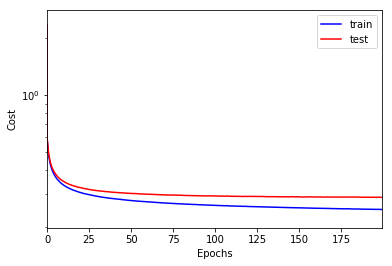

In [116]:
metrics.plot_cost_curves()

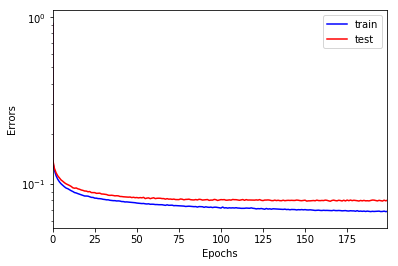

Train/test error after epoch 199: 0.068554, 0.080000


In [117]:
metrics.plot_error_curves()
metrics.print_latest_errors()

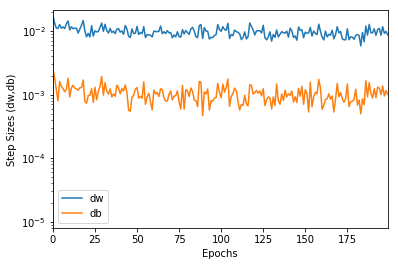

In [118]:
metrics.plot_stepsize_curves()

### Describe your Findings for Exercise 1b

By running the training with different settings for learning rate, number of epochs, batch size explore which combination is best suited to obtain good test performance. Keep an eye on random estimates for the error rates due to random parameter initialisation and randomly shuffled mini-batches. 

Specify your choice of these hyper-parameters and justify why you consider your choice best suited.

#### YOUR FINDINGS ...

- 
- 
- 
- 



Comments just for the group:
- It does not run as expected!
--> it looks like it is overfitting because the train error gets smaller and smaller but the test error is at a minimum (not a good minimum!) after just ~5 epochs and is increasing after that!
- there must be a mistake somewhere in the notebook
- also the test cost is not a number after ~4-5 epochs --> why?
- this leads to a wrong plot in the plot_cost_curve
-  norm goes to infinety --> leads to nan in ypred -> 
   leads to nan in p -> leads to nan in ypred_test (only with test data!)
   --> X test data must be flawed! x_test has the right shape (10,14000) 
   and consists of zeros

#### Plot the Misclassified Images

1120
[[7 7 9 7 3 9 0 2 7 3 0 5 2 9 5 8 4 8 7 9 7 7 5 6 3]]
[9 4 8 2 5 5 3 1 9 2 3 8 4 7 1 1 9 3 9 3 8 9 6 9 5]


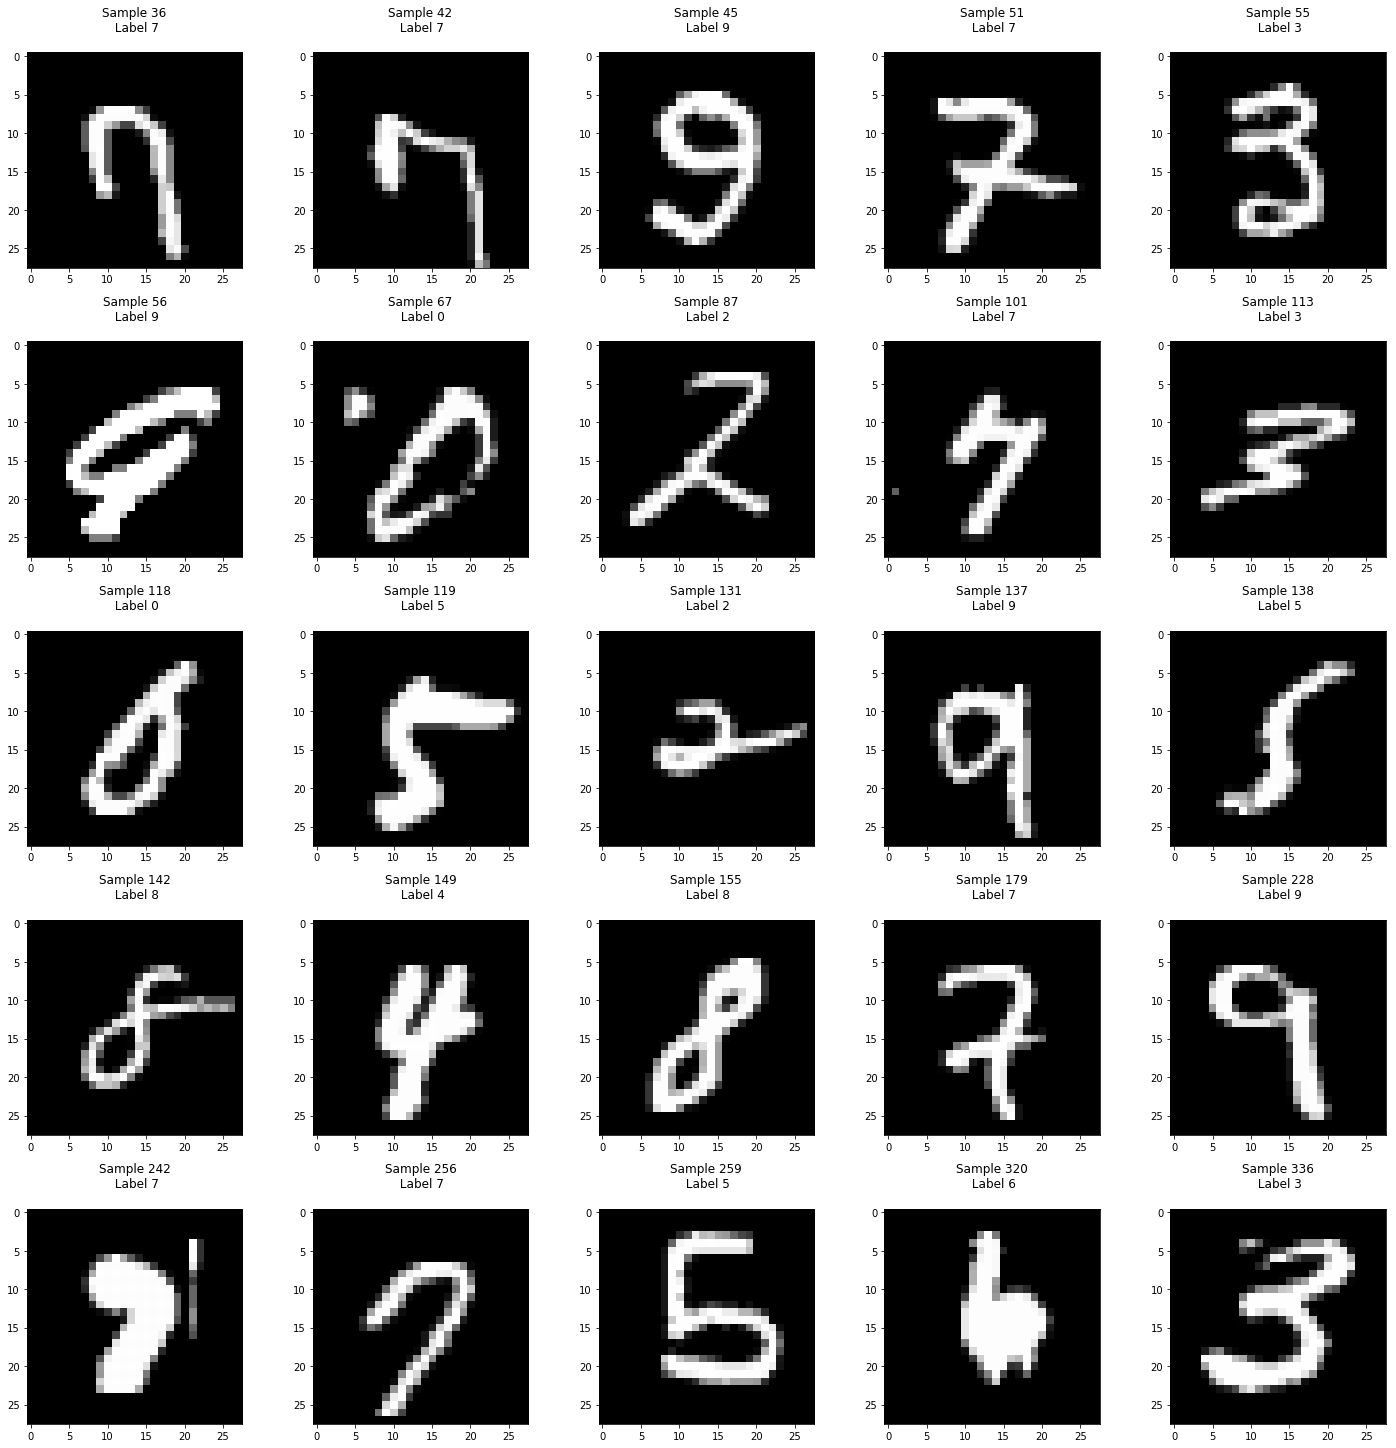

In [119]:
y_pred = predict(params['W'], params['b'], x_test)
yhat = np.argmax(y_pred, axis=0)
indices = np.where(yhat != y_test)[1]
print(len(indices))

plot_digits(x_test, y_test, indices[0:25], shape)
print(y_test[:,indices[0:25]])
print(yhat[indices[0:25]])

### Plot the Trained Weights as Image 

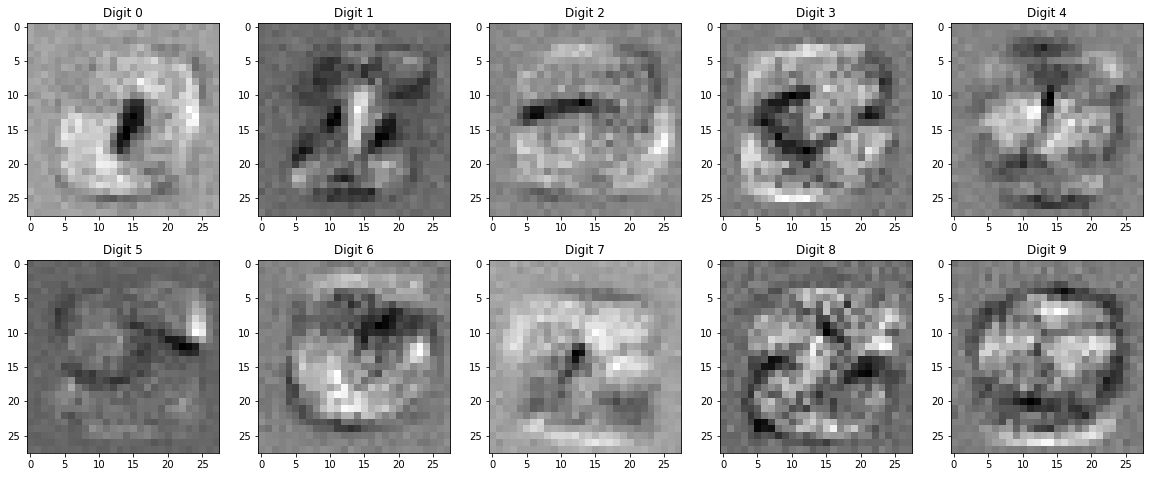

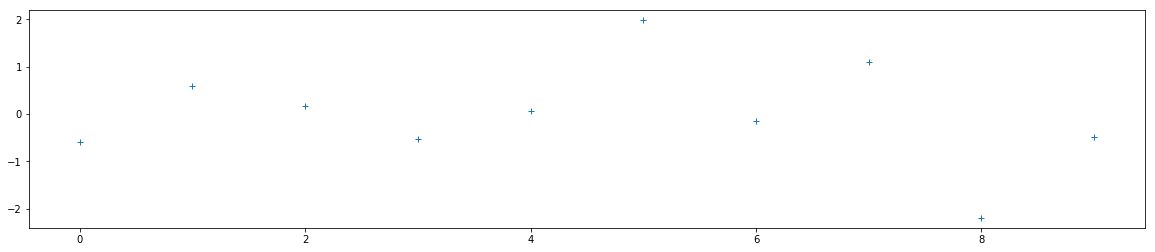

In [120]:
weights = params['W']
biases = params['b']
cols = 5
rows = 2
plt.figure(figsize=(20,4*rows))
for i in range(10):
    plt.subplot(rows, cols, i+1)
    plt.imshow(np.reshape(weights[i], (28,28)), cmap=plt.cm.gray)
    plt.title('Digit %i'%i, fontsize = 12)

plt.figure(figsize=(20,4))
plt.plot(range(10), [biases[i] for i in range(10)], '+')
